Overview

1) load dataset

2) Identify date range of dataset

3) Preprocessing
        - remove leading/trailing whitespace
        - check for null/missing data/duplicates
        - check for outlier with boxplot/histogram
        - check for high cardinality and correlation
        - find unique values and count of each column
        
4) Feature engineering
        - explore and plot relationship of is fraud/not fraud for each column
        -feature extraction done on dob and unix time to get age and hour (0-23)
        - noted merchant/category/street/city/age/job/hour/amt seems to have impact on fraud or not
        - label encode merchant/city/job as there are too many unique category
        - one hot encode category
        - drop features not selected and prepare df from training
        - algorithm selected
                        - Linear Discriminant Analysis (LDA)
                        - Gaussian Naive Bayes (GaussianNB)
                        - GradientBoostingClassifier
                        - XGBClassifier
                        - CatBoost
                        
5) Evaluate model
        - evaluate all model in train and test data using confusion matrix and AUC
        
6) Save best performing model to pkl file

7) Evaluate feature importance of chosen model

Imbalance data were used as there were too little fraud cases compared to not fraud. Training on balanced data could be tested.

Hyperparameters tuning could be done using gridsearch or random search to further enhance model performance.

TRAINING RESULT:

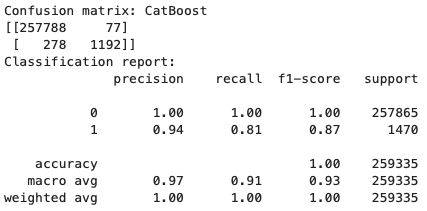

AUC: 0.9982584833518461

TESTING RESULT:

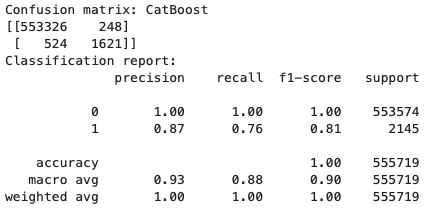


AUC: 0.9970078023946162        
    

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
# from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
train_data = pd.read_csv("train.csv", low_memory=False)
test_data = pd.read_csv("test.csv", low_memory=False)


In [3]:
train_data.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud
0,308467,26ad750c2ff71f32631b58913582d70a,2024-01-10,06:49:39,1704887379,misc_pos,188.38,676355457570,Andrea,Johnson,...,62220,38.5127,-89.9847,95666,Accounting technician,1983-05-26,fraud_Turcotte-Halvorson,39.268874,-89.273447,0
1,261578,fea9c1efe3f2b97f27ad0ab5409ec861,2024-01-06,02:37:50,1704526670,grocery_pos,102.63,377178373574671,Rhonda,Chavez,...,21784,39.4567,-76.9696,37941,"Designer, graphic",1976-12-03,fraud_Schamberger-O'Keefe,39.961495,-76.707640,0
2,341,2ae350b982be840f3666273e0c2f3a05,2024-01-18,21:40:21,1705632021,entertainment,1.62,3599292013370451,Stephen,Khan,...,49735,45.0125,-84.6723,19515,Careers information officer,1999-08-24,"fraud_Nicolas, Hills and McGlynn",44.393561,-85.342323,0
3,1147639,bbdd8adfc0a34ed0e817f809193c85c0,2024-01-21,16:20:15,1705872015,health_fitness,5.64,3594292572430345,Justin,Reilly,...,44256,41.1404,-81.8584,62039,"Merchandiser, retail",1930-02-24,fraud_Cormier LLC,40.283764,-81.639361,0
4,314152,fc7756004dc2a9bc450eb894a670b804,2024-01-21,19:36:26,1705883786,health_fitness,97.09,4867547663675548,Alice,Duarte,...,91501,34.1862,-118.3009,106841,Prison officer,1951-10-15,fraud_Kulas Group,35.149704,-118.087440,0


In [4]:
# find date range of data
min_date = train_data.iloc[:, 2].min()
max_date = train_data.iloc[:, 2].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

Minimum date: 2024-01-01
Maximum date: 2024-01-31


In [5]:
# # set column 1 as the index
# train_data = train_data.set_index("Unnamed: 0")

In [6]:
train_data.shape

(370703, 24)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370703 entries, 0 to 370702
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          370703 non-null  int64  
 1   trans_num   370703 non-null  object 
 2   trans_date  370703 non-null  object 
 3   trans_time  370703 non-null  object 
 4   unix_time   370703 non-null  int64  
 5   category    370703 non-null  object 
 6   amt         370703 non-null  float64
 7   cc_num      370703 non-null  int64  
 8   first       370703 non-null  object 
 9   last        370703 non-null  object 
 10  gender      370703 non-null  object 
 11  street      370703 non-null  object 
 12  city        370703 non-null  object 
 13  state       370703 non-null  object 
 14  zip         370703 non-null  int64  
 15  lat         370703 non-null  float64
 16  long        370703 non-null  float64
 17  city_pop    370703 non-null  int64  
 18  job         370703 non-null  object 
 19  do

In [8]:
train_data.describe()

,id,unix_time,amt,cc_num,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud
count,3.707030e+05,3.707030e+05,370703.000000,3.707030e+05,370703.000000,370703.000000,370703.000000,3.707030e+05,370703.000000,370703.000000,370703.000000
mean,4.080297e+05,1.705433e+09,123.499358,3.862304e+17,51525.494701,37.528550,-92.158261,2.991079e+05,37.527942,-92.158460,0.114105
std,3.361065e+05,7.615549e+05,244.813193,1.260746e+18,29974.830535,5.282128,16.623988,5.644602e+05,5.313384,16.632693,0.317939
min,0.000000e+00,1.704085e+09,1.000000,6.040027e+10,1001.000000,19.207900,-162.305600,1.040000e+02,18.210010,-163.171646,0.000000
25%,1.325125e+05,1.704729e+09,12.360000,1.800195e+14,27705.000000,33.851200,-99.103700,1.924000e+04,33.763643,-99.329107,0.000000
50%,3.162290e+05,1.705435e+09,52.210000,3.513445e+15,48214.000000,38.471800,-87.453200,6.381200e+04,38.371536,-87.197353,0.000000
75%,6.121395e+05,1.706073e+09,106.260000,4.643524e+15,78501.000000,41.230800,-80.063800,2.428030e+05,41.298640,-79.776034,0.000000
max,1.344214e+06,1.706764e+09,17620.830000,4.999601e+18,99921.000000,64.854400,-67.040800,2.906700e+06,65.819961,-66.249287,1.000000


In [9]:
# Check for leading whitespace in object columns
obj_cols = train_data.select_dtypes(include=['object']).columns
leading_whitespace = train_data[obj_cols].apply(lambda x: x.str.contains('^\s', na=False))
print("Columns with leading whitespace:")
print(leading_whitespace.any()[leading_whitespace.any() == True])
print("Rows with leading whitespace:")
print(leading_whitespace[leading_whitespace.any(axis=1)])

# Check for trailing whitespace in object columns
trailing_whitespace = train_data[obj_cols].apply(lambda x: x.str.contains('\s$', na=False))
print("Columns with trailing whitespace:")
print(trailing_whitespace.any()[trailing_whitespace.any() == True])
print("Rows with trailing whitespace:")
print(trailing_whitespace[trailing_whitespace.any(axis=1)])

Columns with leading whitespace:
Series([], dtype: bool)
Rows with leading whitespace:
Empty DataFrame
Columns: [trans_num, trans_date, trans_time, category, first, last, gender, street, city, state, job, dob, merchant]
Index: []
Columns with trailing whitespace:
Series([], dtype: bool)
Rows with trailing whitespace:
Empty DataFrame
Columns: [trans_num, trans_date, trans_time, category, first, last, gender, street, city, state, job, dob, merchant]
Index: []


In [10]:
train_data.isnull().sum()

id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

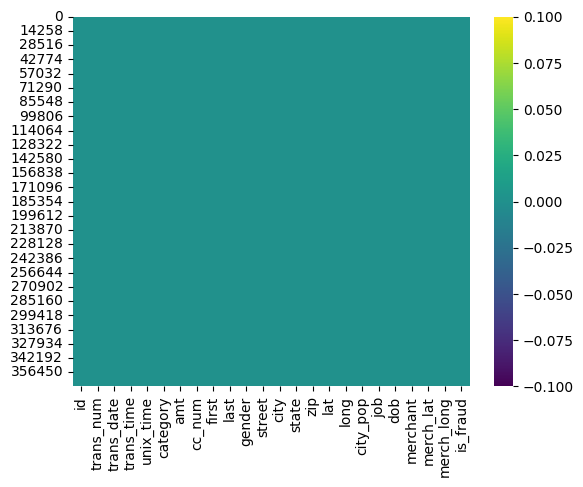

In [11]:
# check for missing data with a heatmap

# Create heatmap
sns.heatmap(train_data.isnull(), cmap='viridis')

# Show plot
plt.show()

In [12]:
# find out if there are any duplicated rows

# identify duplicate rows
duplicates = train_data.duplicated()

# print the duplicate rows
print(train_data[duplicates])

Empty DataFrame
Columns: [id, trans_num, trans_date, trans_time, unix_time, category, amt, cc_num, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, merchant, merch_lat, merch_long, is_fraud]
Index: []

[0 rows x 24 columns]


<Axes: ylabel='amt'>

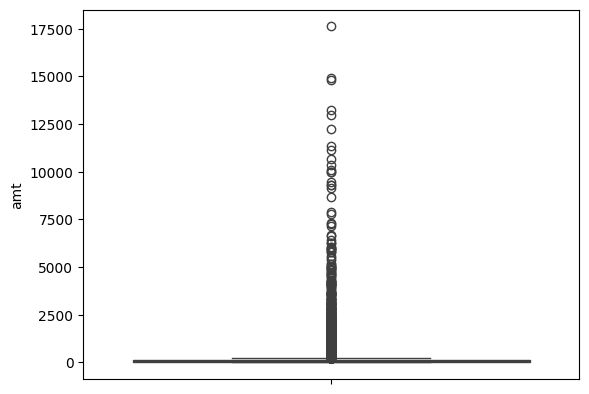

In [13]:
sns.boxplot(data=train_data['amt'])

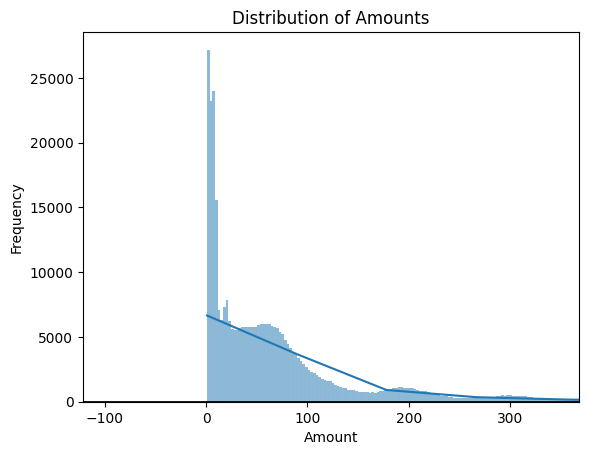

In [14]:
# Plot a histogram of the data to visualize the distribution within 1 standard deviation
sns.histplot(data=train_data, x='amt', kde=True)

mu, std = norm.fit(train_data['amt'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Distribution of Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(mu - 1.0*std, mu + 1.0*std)
plt.show()

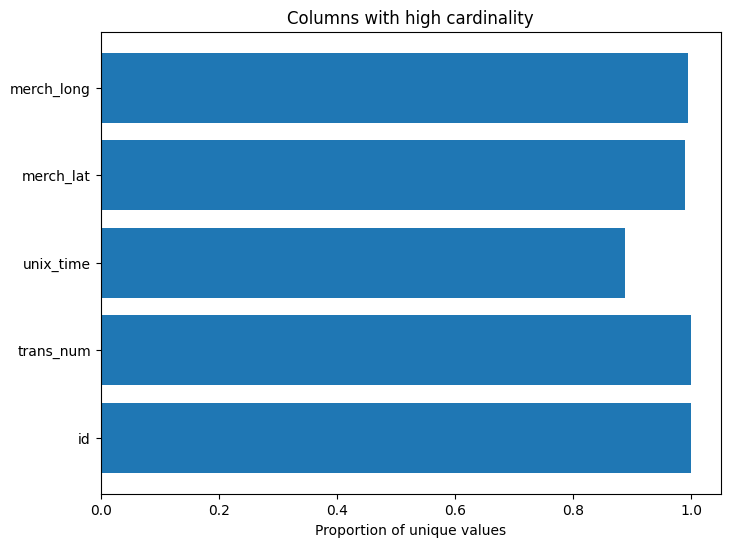

In [15]:
# HIGH CARDINALITY
# calculate the proportion of unique values for each column
prop_unique = train_data.nunique() / len(train_data)

# select columns where the proportion of unique values is above a threshold
threshold = 0.5 # for example, 50%
high_card_cols = prop_unique[prop_unique > threshold]

# plot the proportion of unique values for each column
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(high_card_cols.index, high_card_cols.values)
ax.set_xlabel('Proportion of unique values')
ax.set_title('Columns with high cardinality')
plt.show()

Pairs of variables with high correlation:
('long', 'zip', -0.927168578945691)
('merch_lat', 'lat', 0.9940969630165702)
('merch_long', 'zip', -0.9266071647046796)
('merch_long', 'long', 0.9993992747775414)


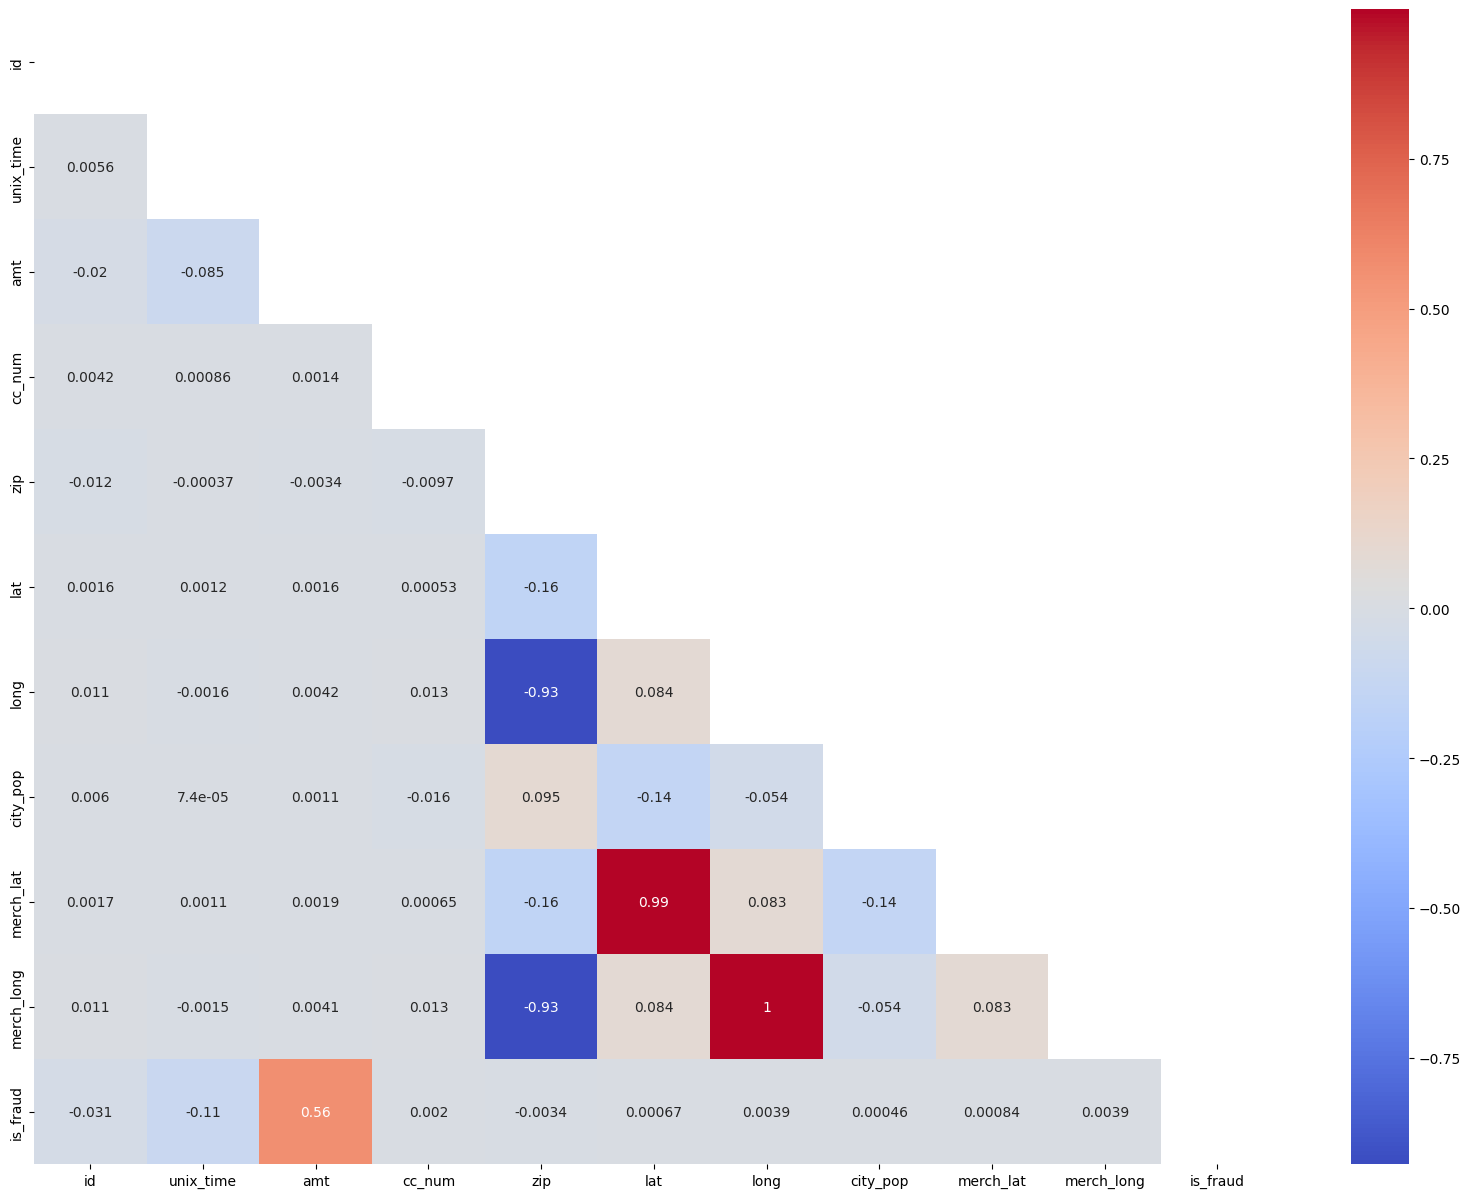

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = train_data.select_dtypes(include=[np.number])

# calculate the correlation matrix
corr_matrix = numeric_data.corr()

# create a mask to hide the upper triangle of the matrix (which is redundant)
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# plot the correlation matrix as a heatmap
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, ax=ax)

# find pairs of variables with high correlation (absolute value greater than a threshold)
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            high_corr_pairs.append((col_i, col_j, corr_matrix.iloc[i, j]))

print('Pairs of variables with high correlation:')
for pair in high_corr_pairs:
    print(pair)

In [17]:
# print unique and count for each column with object dtype
# for categorical columns, find count of each unique category
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        print(f"{col}:\n{train_data[col].value_counts()}\n")

trans_num:
trans_num
26ad750c2ff71f32631b58913582d70a    1
a6b201749230cd8e2617c4e85ffba74f    1
e1137eee3e3474410a94d7223e449672    1
9112d5eab76c84024e28dfb0fffee236    1
ed082e9766ac9c71e2cf2baf03fc034f    1
                                   ..
f6663c474c06bff553d288d6e84ca53d    1
91e01c259491972cffb66a477979f51e    1
2f2de3ebbbcbe1c2aed1b9cb0e6b18af    1
f856d462b7ae59f62725b77f05b41a23    1
f4e27b8542e8911821c40a6f329e2c52    1
Name: count, Length: 370703, dtype: int64

trans_date:
trans_date
2024-01-21    16958
2024-01-14    16852
2024-01-07    16728
2024-01-20    16585
2024-01-06    16463
2024-01-13    16399
2024-01-27    16113
2024-01-28    15989
2024-01-05    14637
2024-01-19    14576
2024-01-12    14552
2024-01-26    13868
2024-01-24    10639
2024-01-03    10610
2024-01-11    10558
2024-01-10    10532
2024-01-17    10521
2024-01-04    10349
2024-01-18    10334
2024-01-25    10120
2024-01-09     9851
2024-01-23     9737
2024-01-16     9605
2024-01-31     9597
2024-01-02     

In [18]:
train_fraud = train_fraud = train_data[train_data['is_fraud'] == 1]
train_fraud.head()


,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud
10,208778,91420c07859f46ac2dce3148cc318cc3,2024-01-07,15:40:07,1704660007,shopping_net,756.96,3507966936742307,Jill,Medina,...,54473,44.6622,-89.3356,2700,Fitness centre manager,1936-11-28,fraud_Cormier LLC,44.391958,-89.931593,1
11,136171,88940a0cd3dbcbaf8e075dddb063043b,2024-01-05,01:39:38,1704436778,gas_transport,327.32,373951312436416,Ruth,Snyder,...,91101,34.1468,-118.1391,153114,"Production designer, theatre/television/film",1972-05-17,"fraud_Connelly, Reichert and Fritsch",34.057928,-117.760396,1
12,415403,20f9ad95aa85884302c786d609d9da0a,2024-01-19,22:14:25,1705720465,grocery_pos,18.65,4706065468693033,Zachary,Rubio,...,73170,35.3270,-97.5556,640470,Public relations officer,1972-04-01,fraud_Koepp-Witting,35.518037,-98.154418,1
19,122087,748d239329f69bdd4545befa4bf20afa,2024-01-12,01:30:35,1705041035,grocery_pos,367.65,4177738684042504,Robert,Williams,...,7444,40.9655,-74.3016,11046,"Conservator, furniture",1953-05-20,fraud_Hudson-Ratke,41.316029,-73.743772,1
26,1305252,19493a67792831a91fee807fb32dc9f6,2024-01-03,23:45:40,1704343540,health_fitness,20.63,4688709928015905,Raven,Daniels,...,75225,32.8628,-96.7918,1263321,Financial adviser,1983-08-17,fraud_Thompson-Gleason,32.075888,-96.389876,1


In [19]:
# print unique and count for each column with object dtype
# for categorical columns, find count of each unique category
for col in train_fraud.columns:
    if train_fraud[col].dtype == 'object':
        print(f"{col}:\n{train_fraud[col].value_counts()}\n")

trans_num:
trans_num
91420c07859f46ac2dce3148cc318cc3    1
b28819746a9ea5127e27da486f616aca    1
38519624e2e860ee8fdcf58fe5a3120e    1
ee4866f4c81fbbf01f7c00910c7a4421    1
5dba1d725ff806ae1280985e585b55c7    1
                                   ..
f59d79981fab4f20738bac484c36e32a    1
20440bb87322e31b56da8c0603ccc3ee    1
432d9057af3d1506c47358439b46bfd8    1
a2ebcfa54efc8d80edbea19fbe6e6f51    1
8241d65a2a63ada8daa3e81552404726    1
Name: count, Length: 42299, dtype: int64

trans_date:
trans_date
2024-01-07    2213
2024-01-21    2211
2024-01-14    2068
2024-01-05    2035
2024-01-06    2020
2024-01-10    1948
2024-01-19    1946
2024-01-09    1916
2024-01-03    1905
2024-01-13    1900
2024-01-12    1893
2024-01-24    1880
2024-01-20    1867
2024-01-17    1851
2024-01-23    1803
2024-01-16    1755
2024-01-04    1754
2024-01-11    1650
2024-01-18    1635
2024-01-22    1476
2024-01-08    1422
2024-01-15    1367
2024-01-25     918
2024-01-02     866
Name: count, dtype: int64

trans_time:
t

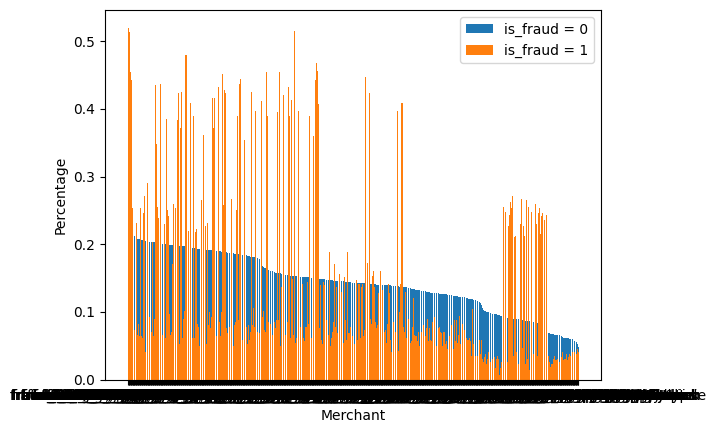

In [20]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'merchant' column
counts_0 = fraud_0['merchant'].value_counts()
counts_1 = fraud_1['merchant'].value_counts()

# Calculate the percentage of occurrences for each merchant in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each merchant name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('Merchant')
plt.ylabel('Percentage')
plt.legend()
plt.show()


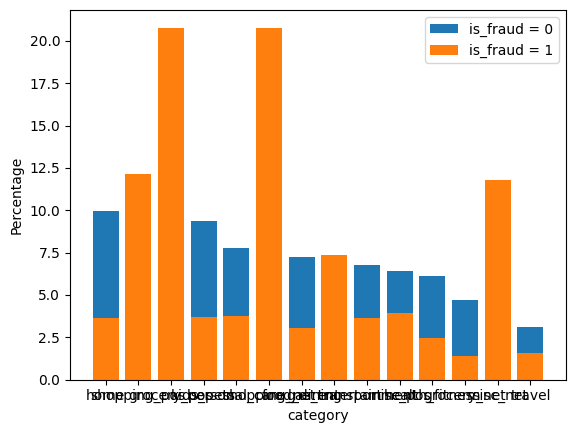

In [21]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'merchant' column
counts_0 = fraud_0['category'].value_counts()
counts_1 = fraud_1['category'].value_counts()

# Calculate the percentage of occurrences for each merchant in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each merchant name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('category')
plt.ylabel('Percentage')
plt.legend()
plt.show()

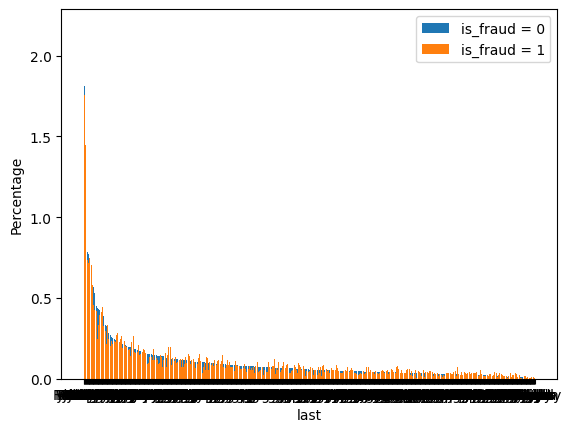

In [22]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'merchant' column
counts_0 = fraud_0['last'].value_counts()
counts_1 = fraud_1['last'].value_counts()

# Calculate the percentage of occurrences for each merchant in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each merchant name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('last')
plt.ylabel('Percentage')
plt.legend()
plt.show()

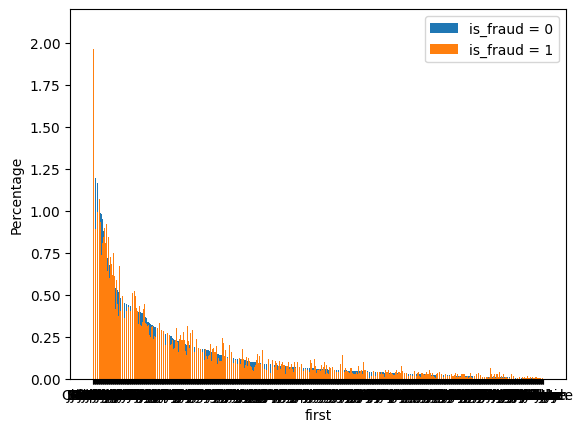

In [23]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'merchant' column
counts_0 = fraud_0['first'].value_counts()
counts_1 = fraud_1['first'].value_counts()

# Calculate the percentage of occurrences for each merchant in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each merchant name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('first')
plt.ylabel('Percentage')
plt.legend()
plt.show()

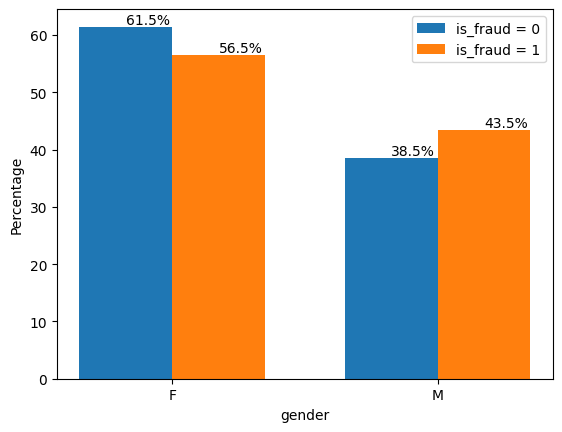

In [24]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'gender' column
counts_0 = fraud_0['gender'].value_counts()
counts_1 = fraud_1['gender'].value_counts()

# Calculate the percentage of occurrences for each gender in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars for each condition
pos_0 = np.arange(len(percent_0))
pos_1 = pos_0 + bar_width

# Create a bar chart with the percentage for each gender name in both conditions
plt.bar(pos_0, percent_0.values, width=bar_width, label='is_fraud = 0')
plt.bar(pos_1, percent_1.values, width=bar_width, label='is_fraud = 1')

# Label each bar with the percentage
for i, p in enumerate(pos_0):
    plt.text(p, percent_0.values[i]+0.5, '{:.1f}%'.format(percent_0.values[i]))
for i, p in enumerate(pos_1):
    plt.text(p, percent_1.values[i]+0.5, '{:.1f}%'.format(percent_1.values[i]))

plt.xticks(pos_0 + bar_width / 2, percent_0.index)
plt.xlabel('gender')
plt.ylabel('Percentage')
plt.legend()
plt.show()



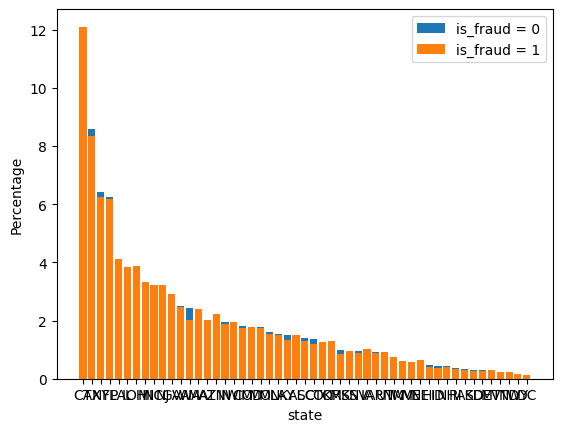

In [25]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'merchant' column
counts_0 = fraud_0['state'].value_counts()
counts_1 = fraud_1['state'].value_counts()

# Calculate the percentage of occurrences for each merchant in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each merchant name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('state')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [26]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Convert 'dob' to datetime format
train_data['dob'] = pd.to_datetime(train_data['dob'])

# Get current date
today = datetime.today()

# Calculate age in years and save to new column
train_data['age'] = train_data['dob'].apply(lambda dob: relativedelta(today, dob).years)

Minimum age: 25
Maximum age: 96
Mean age: 45.74987793462691
Mode age: 49
Median age: 43.0


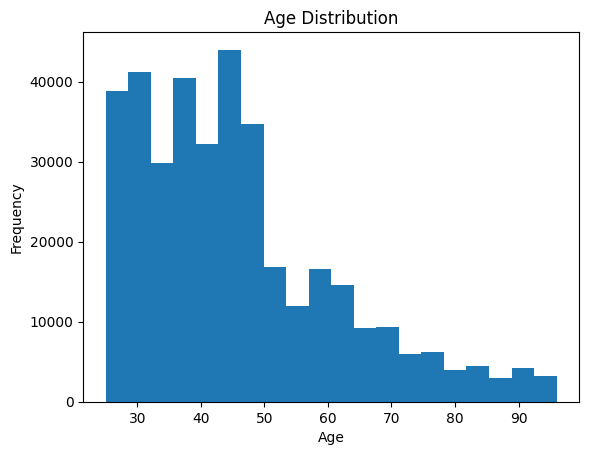

In [27]:
# Calculate statistics
min_age = train_data['age'].min()
max_age = train_data['age'].max()
mean_age = train_data['age'].mean()
mode_age = train_data['age'].mode()[0]
median_age = train_data['age'].median()

# Print statistics
print(f"Minimum age: {min_age}")
print(f"Maximum age: {max_age}")
print(f"Mean age: {mean_age}")
print(f"Mode age: {mode_age}")
print(f"Median age: {median_age}")

# Plot distribution
plt.hist(train_data['age'], bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


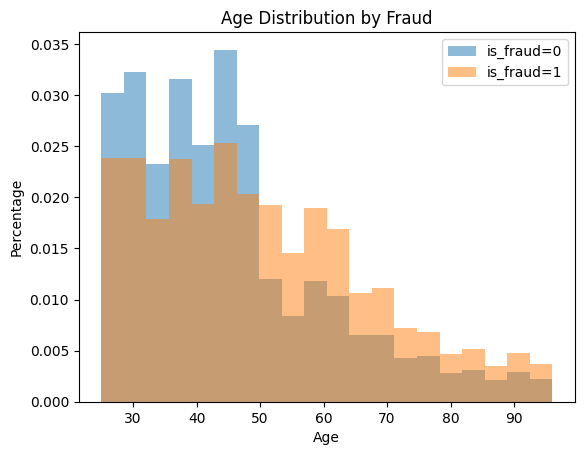

In [28]:
# Get total number of records for each fraud status
total_fraud_0 = len(train_data[train_data['is_fraud']==0])
total_fraud_1 = len(train_data[train_data['is_fraud']==1])

# Plot age distribution of fraud=0
plt.hist(train_data[train_data['is_fraud']==0]['age'], bins=20, alpha=0.5, label='is_fraud=0', density=True)
# Plot age distribution of fraud=1
plt.hist(train_data[train_data['is_fraud']==1]['age'], bins=20, alpha=0.5, label='is_fraud=1', density=True)

plt.title('Age Distribution by Fraud')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.legend(loc='upper right')

plt.show()

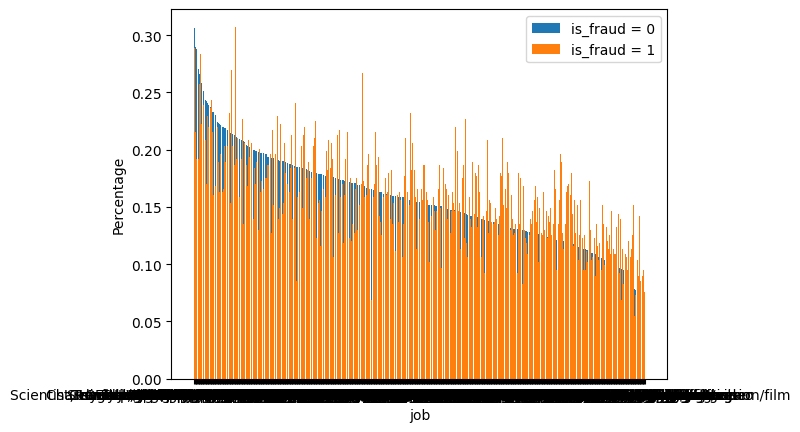

In [29]:
# Separate the data by 'is_fraud' conditions
fraud_0 = train_data[train_data['is_fraud'] == 0]
fraud_1 = train_data[train_data['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'merchant' column
counts_0 = fraud_0['job'].value_counts()
counts_1 = fraud_1['job'].value_counts()

# Calculate the percentage of occurrences for each merchant in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each merchant name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('job')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [30]:
# Group the DataFrame by city and count the number of unique city_pop values for each city
city_pop_counts = train_data.groupby('city')['city_pop'].nunique()

# Loop over the unique cities and print the number of unique city_pop values for each city with more than one unique city_pop value
for city in city_pop_counts[city_pop_counts > 1].index:
    print(f"{city}: {city_pop_counts[city]} unique city_pop values")



Abbeville: 4 unique city_pop values
Aberdeen: 6 unique city_pop values
Abingdon: 2 unique city_pop values
Ada: 2 unique city_pop values
Adair: 2 unique city_pop values
Adams: 2 unique city_pop values
Addison: 2 unique city_pop values
Akron: 3 unique city_pop values
Alamo: 2 unique city_pop values
Albany: 5 unique city_pop values
Albion: 3 unique city_pop values
Aledo: 2 unique city_pop values
Alexandria: 4 unique city_pop values
Allen: 2 unique city_pop values
Allendale: 2 unique city_pop values
Allentown: 2 unique city_pop values
Alma: 2 unique city_pop values
Alpine: 2 unique city_pop values
Alto: 2 unique city_pop values
Alton: 2 unique city_pop values
Altoona: 2 unique city_pop values
Amherst: 2 unique city_pop values
Anderson: 4 unique city_pop values
Andover: 4 unique city_pop values
Andrews: 2 unique city_pop values
Angola: 2 unique city_pop values
Annandale: 2 unique city_pop values
Annapolis: 2 unique city_pop values
Antioch: 2 unique city_pop values
Arcadia: 4 unique city_pop

In [31]:
# Group the DataFrame by city and collect the unique city_pop values for each city with more than one unique city_pop value
city_pop_unique = train_data[train_data['city'].isin(city_pop_counts[city_pop_counts > 1].index)].groupby(['city'])['city_pop'].unique()

# Loop over the unique cities and print the unique city_pop values for each city with more than one unique city_pop value
for city in city_pop_unique.index:
    print(f"{city}: {city_pop_unique[city]}")


Abbeville: [12934  4816 25313  6783]
Aberdeen: [21487  3449 23814 11805 30061 11681]
Abingdon: [26762 29766]
Ada: [30802  8460]
Adair: [2884 1297]
Adams: [8603 4777]
Addison: [ 5475 39119]
Akron: [272134   9464   3360]
Alamo: [33722 14889]
Albany: [151022   5266  19615  58967 101511]
Albion: [ 2041 14224  6581]
Aledo: [ 5627 13602]
Alexandria: [321490  58923  23961  16412]
Allen: [93487   487]
Allendale: [ 4990 20735]
Allentown: [166081   6582]
Alma: [13787 12923]
Alpine: [ 9818 17403]
Alto: [7585 4179]
Alton: [32704  3613]
Altoona: [63424  7039]
Amherst: [39421 11247]
Anderson: [79310 22841 93613  5879]
Andover: [33201 45967  2159  9193]
Andrews: [14786 11060]
Angola: [ 9858 18029]
Annandale: [55990  8551]
Annapolis: [92106  1619]
Antioch: [102729  78406]
Arcadia: [ 2178  5152  3308 65810]
Arlington: [370281 207410  40815  42844  38927]
Arnold: [35439 21317]
Asbury: [ 731 4067]
Ashland: [40470 32345  5704 24469  7676 15227 16593  1117 11810]
Astoria: [148476  16859]
Athens: [ 53253 11

In [32]:
unique_city_pop = train_data['city_pop'].nunique()
print(f"There are {unique_city_pop} unique city_pop values in the train_data DataFrame.")


There are 5889 unique city_pop values in the train_data DataFrame.


In [33]:
# Assuming 'unix_time' is the column containing Unix time in your DataFrame
train_data['hour'] = pd.to_datetime(train_data['unix_time'], unit='s').dt.hour

# Categorize the hour column into 24 different categories according to 24 hours
train_data['hour_category'] = pd.cut(train_data['hour'], bins=24, labels=range(24))


In [34]:
train_data['hour_category'].unique()

[11, 7, 2, 21, 0, ..., 9, 15, 23, 13, 12]
Length: 24
Categories (24, int64): [0 < 1 < 2 < 3 ... 20 < 21 < 22 < 23]

/var/folders/tc/9srvxb_11h5bpdgnjy16lbqr0000gn/T/ipykernel_22711/830389467.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_data.groupby(['hour_category', 'is_fraud']).size()


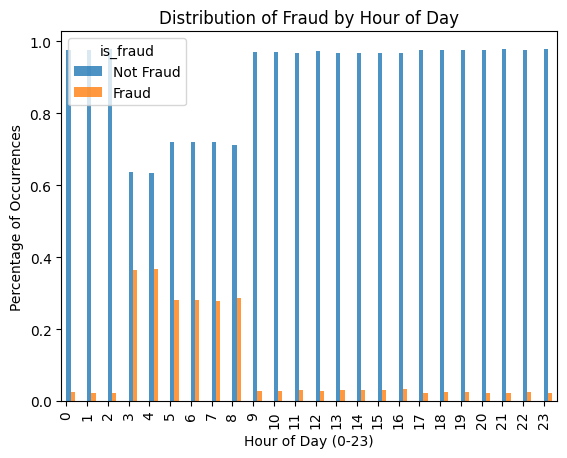

In [35]:
# Group the DataFrame by hour category and is_fraud, and count the occurrences in each group
counts = train_data.groupby(['hour_category', 'is_fraud']).size()

# Reshape the counts into a DataFrame with hour categories as rows and is_fraud values as columns
counts_df = counts.unstack()

# Normalize the counts for each hour category to show the percentage of occurrences for each is_fraud value
norm_counts_df = counts_df.div(counts_df.sum(axis=1), axis=0)

# Plot the normalized counts as a stacked histogram with hour categories as x-axis and percentage as y-axis
norm_counts_df.plot(kind='bar', position=0, width=0.4, alpha=0.8, color=['#1f77b4', '#ff7f0e'])

# Set the chart title and x-axis label
plt.title('Distribution of Fraud by Hour of Day')
plt.xlabel('Hour of Day (0-23)')

# Set the y-axis label to indicate that the values represent percentages
plt.ylabel('Percentage of Occurrences')

# Show the legend with labels for is_fraud values
plt.legend(title='is_fraud', labels=['Not Fraud', 'Fraud'])

# Display the plot
plt.show()


/var/folders/tc/9srvxb_11h5bpdgnjy16lbqr0000gn/T/ipykernel_22711/1740786235.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train_data[train_data['is_fraud'] == 1].groupby('hour_category').size()


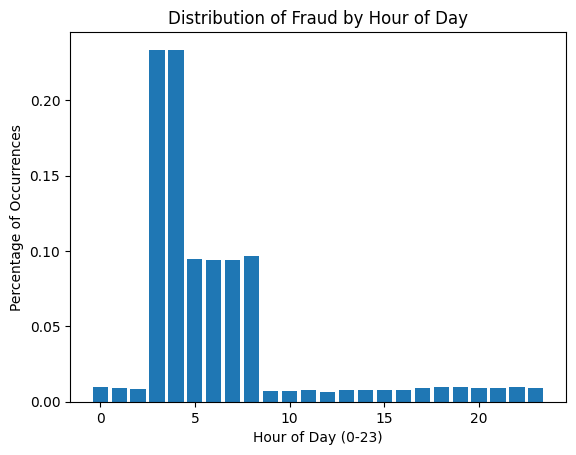

In [36]:
# Group the DataFrame by hour category and is_fraud, and count the occurrences in each group
counts = train_data[train_data['is_fraud'] == 1].groupby('hour_category').size()

# Normalize the counts for each hour category to show the percentage of occurrences for is_fraud=1
norm_counts = counts / counts.sum()

# Plot the normalized counts as a histogram with hour categories as x-axis and percentage as y-axis
plt.bar(norm_counts.index, norm_counts.values)

# Set the chart title and x-axis label
plt.title('Distribution of Fraud by Hour of Day')
plt.xlabel('Hour of Day (0-23)')

# Set the y-axis label to indicate that the values represent percentages
plt.ylabel('Percentage of Occurrences')

# Display the plot
plt.show()



In [37]:
# Compute summary statistics for 'amt' column in fraud_0
print("is_fraud = 0")
print("Minimum:", fraud_0['amt'].min())
print("Maximum:", fraud_0['amt'].max())
print("Mean:", fraud_0['amt'].mean())
print("Median:", fraud_0['amt'].median())
print("Mode:", fraud_0['amt'].mode()[0])
print()

# Compute summary statistics for 'amt' column in fraud_1
print("is_fraud = 1")
print("Minimum:", fraud_1['amt'].min())
print("Maximum:", fraud_1['amt'].max())
print("Mean:", fraud_1['amt'].mean())
print("Median:", fraud_1['amt'].median())
print("Mode:", fraud_1['amt'].mode()[0])


is_fraud = 0
Minimum: 1.0
Maximum: 17620.83
Mean: 73.97875936346692
Median: 47.28
Mode: 1.01

is_fraud = 1
Minimum: 1.07
Maximum: 1382.78
Mean: 507.970919170666
Median: 354.36
Mode: 8.4


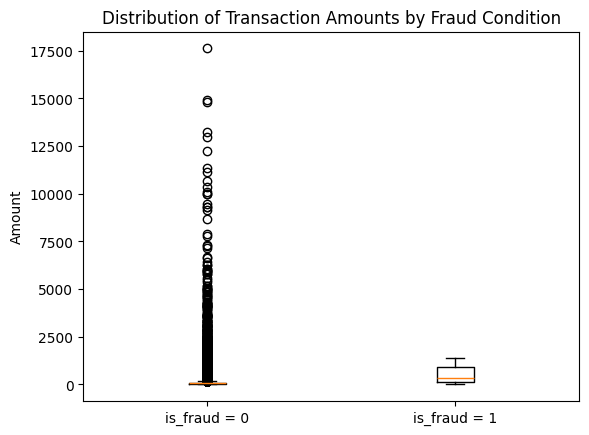

In [38]:
# Create a box plot of 'amt' column for both conditions
plt.boxplot([fraud_0['amt'], fraud_1['amt']])
plt.xticks([1, 2], ['is_fraud = 0', 'is_fraud = 1'])
plt.ylabel('Amount')
plt.title('Distribution of Transaction Amounts by Fraud Condition')
plt.show()


In [39]:
cc_fraud = train_data[train_data['is_fraud'] == 1]['cc_num'].unique()

fraud_1_mask = train_data['is_fraud'] == 1
fraud_0_mask = train_data['is_fraud'] == 0
cc_fraud_mask = train_data['cc_num'].isin(cc_fraud)

num_fraud_1 = len(train_data[cc_fraud_mask & fraud_1_mask])
num_fraud_0 = len(train_data[cc_fraud_mask & fraud_0_mask])

print(len(cc_fraud))
print(num_fraud_1)
print(num_fraud_0)


15246
42299
285483


In [40]:
print(train_data['cc_num'].nunique())


17660


In [41]:
train_data.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud,age,hour,hour_category
0,308467,26ad750c2ff71f32631b58913582d70a,2024-01-10,06:49:39,1704887379,misc_pos,188.38,676355457570,Andrea,Johnson,...,95666,Accounting technician,1983-05-26,fraud_Turcotte-Halvorson,39.268874,-89.273447,0,41,11,11
1,261578,fea9c1efe3f2b97f27ad0ab5409ec861,2024-01-06,02:37:50,1704526670,grocery_pos,102.63,377178373574671,Rhonda,Chavez,...,37941,"Designer, graphic",1976-12-03,fraud_Schamberger-O'Keefe,39.961495,-76.707640,0,48,7,7
2,341,2ae350b982be840f3666273e0c2f3a05,2024-01-18,21:40:21,1705632021,entertainment,1.62,3599292013370451,Stephen,Khan,...,19515,Careers information officer,1999-08-24,"fraud_Nicolas, Hills and McGlynn",44.393561,-85.342323,0,25,2,2
3,1147639,bbdd8adfc0a34ed0e817f809193c85c0,2024-01-21,16:20:15,1705872015,health_fitness,5.64,3594292572430345,Justin,Reilly,...,62039,"Merchandiser, retail",1930-02-24,fraud_Cormier LLC,40.283764,-81.639361,0,94,21,21
4,314152,fc7756004dc2a9bc450eb894a670b804,2024-01-21,19:36:26,1705883786,health_fitness,97.09,4867547663675548,Alice,Duarte,...,106841,Prison officer,1951-10-15,fraud_Kulas Group,35.149704,-118.087440,0,73,0,0


In [42]:
# Drop columns to prepare data for training
train_ans = train_data['is_fraud']

# Drop columns that failed feature selection
columns_to_drop = [
    'trans_num', 'unix_time', 'first', 'last', 'street', 'state', 'zip', 
    'lat', 'long', 'dob', 'merch_lat', 'merch_long', 'is_fraud', 'cc_num', 
    'city_pop'
]

train_data = train_data.drop(columns=columns_to_drop)

# Display the first few rows of the cleaned data
train_data.head()

,id,trans_date,trans_time,category,amt,gender,city,job,merchant,age,hour,hour_category
0,308467,2024-01-10,06:49:39,misc_pos,188.38,F,Belleville,Accounting technician,fraud_Turcotte-Halvorson,41,11,11
1,261578,2024-01-06,02:37:50,grocery_pos,102.63,F,Sykesville,"Designer, graphic",fraud_Schamberger-O'Keefe,48,7,7
2,341,2024-01-18,21:40:21,entertainment,1.62,M,Gaylord,Careers information officer,"fraud_Nicolas, Hills and McGlynn",25,2,2
3,1147639,2024-01-21,16:20:15,health_fitness,5.64,M,Medina,"Merchandiser, retail",fraud_Cormier LLC,94,21,21
4,314152,2024-01-21,19:36:26,health_fitness,97.09,F,Burbank,Prison officer,fraud_Kulas Group,73,0,0


In [43]:
test_data.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,state,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long
0,52329,2e6b34f2047158280fd5b50cb5249fcc,2024-01-27,13:17:44,1706379464,kids_pets,13.00,30184874050384,Edward,Mueller,...,NY,11230,40.6225,-73.9650,2504700,Leisure centre manager,1955-12-17,"fraud_Lowe, Dietrich and Erdman",40.707029,-74.027386
1,92215,5e4c36e1e6f1838f0afe1ed83d42d48e,2024-01-31,21:12:51,1706753571,travel,25.64,3560293989785735,Ryan,Reeves,...,CA,92504,33.9315,-117.4119,419138,Mudlogger,1940-06-22,fraud_Johnston-Casper,34.344545,-117.348319
2,107070,de58b3413be0b956c261b8e756006b5d,2024-01-24,23:06:59,1706155619,home,99.48,213175392060268,Gregory,Graham,...,KY,42629,36.9680,-85.0968,4953,"Engineer, automotive",1993-03-18,"fraud_Gutmann, McLaughlin and Wiza",37.493843,-85.224136
3,117508,63e5e8954b6954121fb9395b8fb87ec3,2024-01-15,14:42:37,1705347757,grocery_pos,972.26,2720994415033785,Jessica,Carey,...,TX,75571,33.1808,-94.7639,2846,Geophysicist/field seismologist,1958-06-30,"fraud_Schoen, Kuphal and Nitzsche",32.238558,-94.085343
4,525132,f0acdc291ca35b61a873060e419b20a5,2024-01-30,22:02:41,1706670161,personal_care,165.04,639070744995,Corey,Rogers,...,NJ,7022,40.8170,-74.0000,13835,"Accountant, chartered public finance",1972-04-13,fraud_Sporer-Keebler,40.957527,-73.328707


In [44]:
# find date range of data
min_date = test_data.iloc[:,2].min()
max_date = test_data.iloc[:, 2].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

Minimum date: 2024-01-01
Maximum date: 2024-01-31


In [45]:
test_data.shape

(92676, 23)

In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92676 entries, 0 to 92675
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          92676 non-null  int64  
 1   trans_num   92676 non-null  object 
 2   trans_date  92676 non-null  object 
 3   trans_time  92676 non-null  object 
 4   unix_time   92676 non-null  int64  
 5   category    92676 non-null  object 
 6   amt         92676 non-null  float64
 7   cc_num      92676 non-null  int64  
 8   first       92676 non-null  object 
 9   last        92676 non-null  object 
 10  gender      92676 non-null  object 
 11  street      92676 non-null  object 
 12  city        92676 non-null  object 
 13  state       92676 non-null  object 
 14  zip         92676 non-null  int64  
 15  lat         92676 non-null  float64
 16  long        92676 non-null  float64
 17  city_pop    92676 non-null  int64  
 18  job         92676 non-null  object 
 19  dob         92676 non-nul

In [47]:
test_data.describe()

,id,unix_time,amt,cc_num,zip,lat,long,city_pop,merch_lat,merch_long
count,9.267600e+04,9.267600e+04,92676.000000,9.267600e+04,92676.000000,92676.000000,92676.000000,9.267600e+04,92676.000000,92676.000000
mean,4.100129e+05,1.705426e+09,123.620303,3.782854e+17,51394.206580,37.540512,-92.094661,3.005724e+05,37.542093,-92.093669
std,3.372584e+05,7.634153e+05,246.509457,1.248289e+18,29980.707237,5.266129,16.615578,5.660214e+05,5.299426,16.624288
min,1.000000e+00,1.704085e+09,1.000000,6.040027e+10,1001.000000,19.207900,-162.305600,1.040000e+02,18.523326,-161.913224
25%,1.329415e+05,1.704719e+09,12.520000,1.800190e+14,27587.000000,33.864300,-98.744200,1.932800e+04,33.787551,-99.110547
50%,3.176790e+05,1.705427e+09,52.545000,3.513937e+15,48204.000000,38.482200,-87.309000,6.384400e+04,38.372361,-87.124983
75%,6.171425e+05,1.706070e+09,106.062500,4.641271e+15,78254.000000,41.254900,-79.983000,2.453170e+05,41.317415,-79.709554
max,1.344260e+06,1.706764e+09,14906.980000,4.999601e+18,99921.000000,64.854400,-67.040800,2.906700e+06,65.666661,-66.552561


In [48]:
# Check for leading whitespace in object columns
obj_cols = test_data.select_dtypes(include=['object']).columns
leading_whitespace = test_data[obj_cols].apply(lambda x: x.str.contains('^\s', na=False))
print("Columns with leading whitespace:")
print(leading_whitespace.any()[leading_whitespace.any() == True])
print("Rows with leading whitespace:")
print(leading_whitespace[leading_whitespace.any(axis=1)])

# Check for trailing whitespace in object columns
trailing_whitespace = test_data[obj_cols].apply(lambda x: x.str.contains('\s$', na=False))
print("Columns with trailing whitespace:")
print(trailing_whitespace.any()[trailing_whitespace.any() == True])
print("Rows with trailing whitespace:")
print(trailing_whitespace[trailing_whitespace.any(axis=1)])

Columns with leading whitespace:
Series([], dtype: bool)
Rows with leading whitespace:
Empty DataFrame
Columns: [trans_num, trans_date, trans_time, category, first, last, gender, street, city, state, job, dob, merchant]
Index: []
Columns with trailing whitespace:
Series([], dtype: bool)
Rows with trailing whitespace:
Empty DataFrame
Columns: [trans_num, trans_date, trans_time, category, first, last, gender, street, city, state, job, dob, merchant]
Index: []


In [49]:
test_data.isnull().sum()

id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

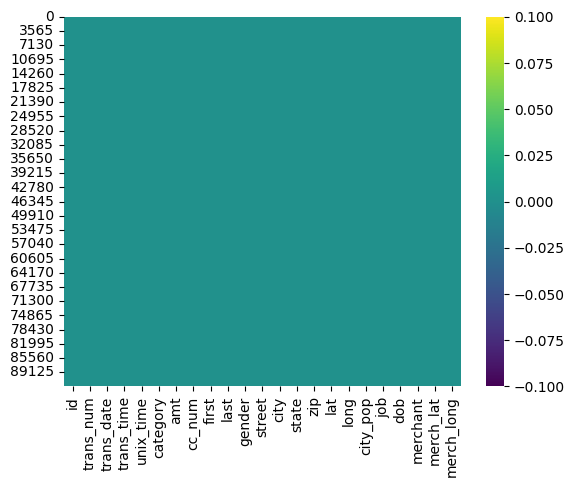

In [50]:
# check for missing data with a heatmap

# Create heatmap
sns.heatmap(test_data.isnull(), cmap='viridis')

# Show plot
plt.show()

In [51]:
# find out if there are any duplicated rows

# identify duplicate rows
duplicates = test_data.duplicated()

# print the duplicate rows
print(test_data[duplicates])

Empty DataFrame
Columns: [id, trans_num, trans_date, trans_time, unix_time, category, amt, cc_num, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, merchant, merch_lat, merch_long]
Index: []

[0 rows x 23 columns]


<Axes: ylabel='amt'>

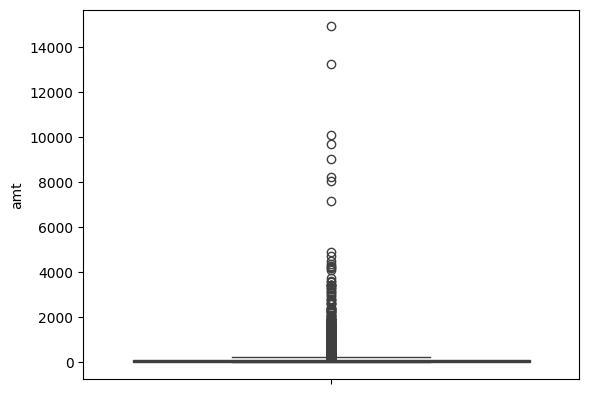

In [52]:
sns.boxplot(data=test_data['amt'])

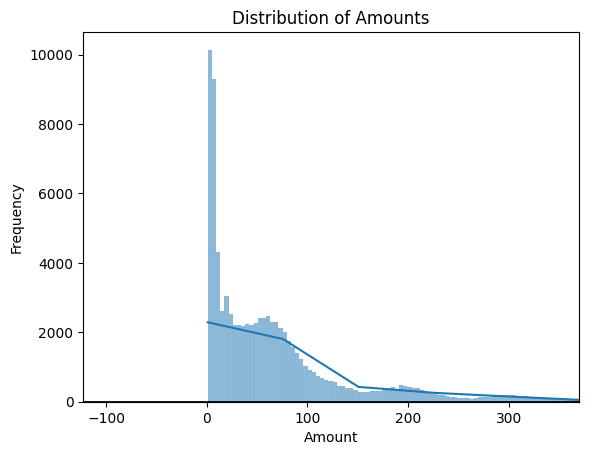

In [53]:
# Plot a histogram of the data to visualize the distribution within 1 standard deviation
sns.histplot(data=test_data, x='amt', kde=True)

mu, std = norm.fit(test_data['amt'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Distribution of Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(mu - 1.0*std, mu + 1.0*std)
plt.show()

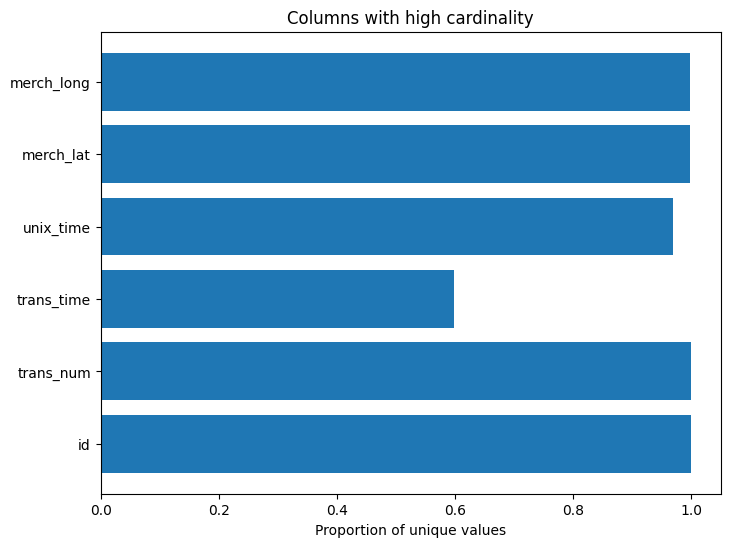

In [54]:
# HIGH CARDINALITY
# calculate the proportion of unique values for each column
prop_unique = test_data.nunique() / len(test_data)

# select columns where the proportion of unique values is above a threshold
threshold = 0.5 # for example, 50%
high_card_cols = prop_unique[prop_unique > threshold]

# plot the proportion of unique values for each column
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(high_card_cols.index, high_card_cols.values)
ax.set_xlabel('Proportion of unique values')
ax.set_title('Columns with high cardinality')
plt.show()

Pairs of variables with high correlation:
('long', 'zip', -0.9273711735776752)
('merch_lat', 'lat', 0.9940722113903676)
('merch_long', 'zip', -0.9268755741589287)
('merch_long', 'long', 0.9994003064350041)


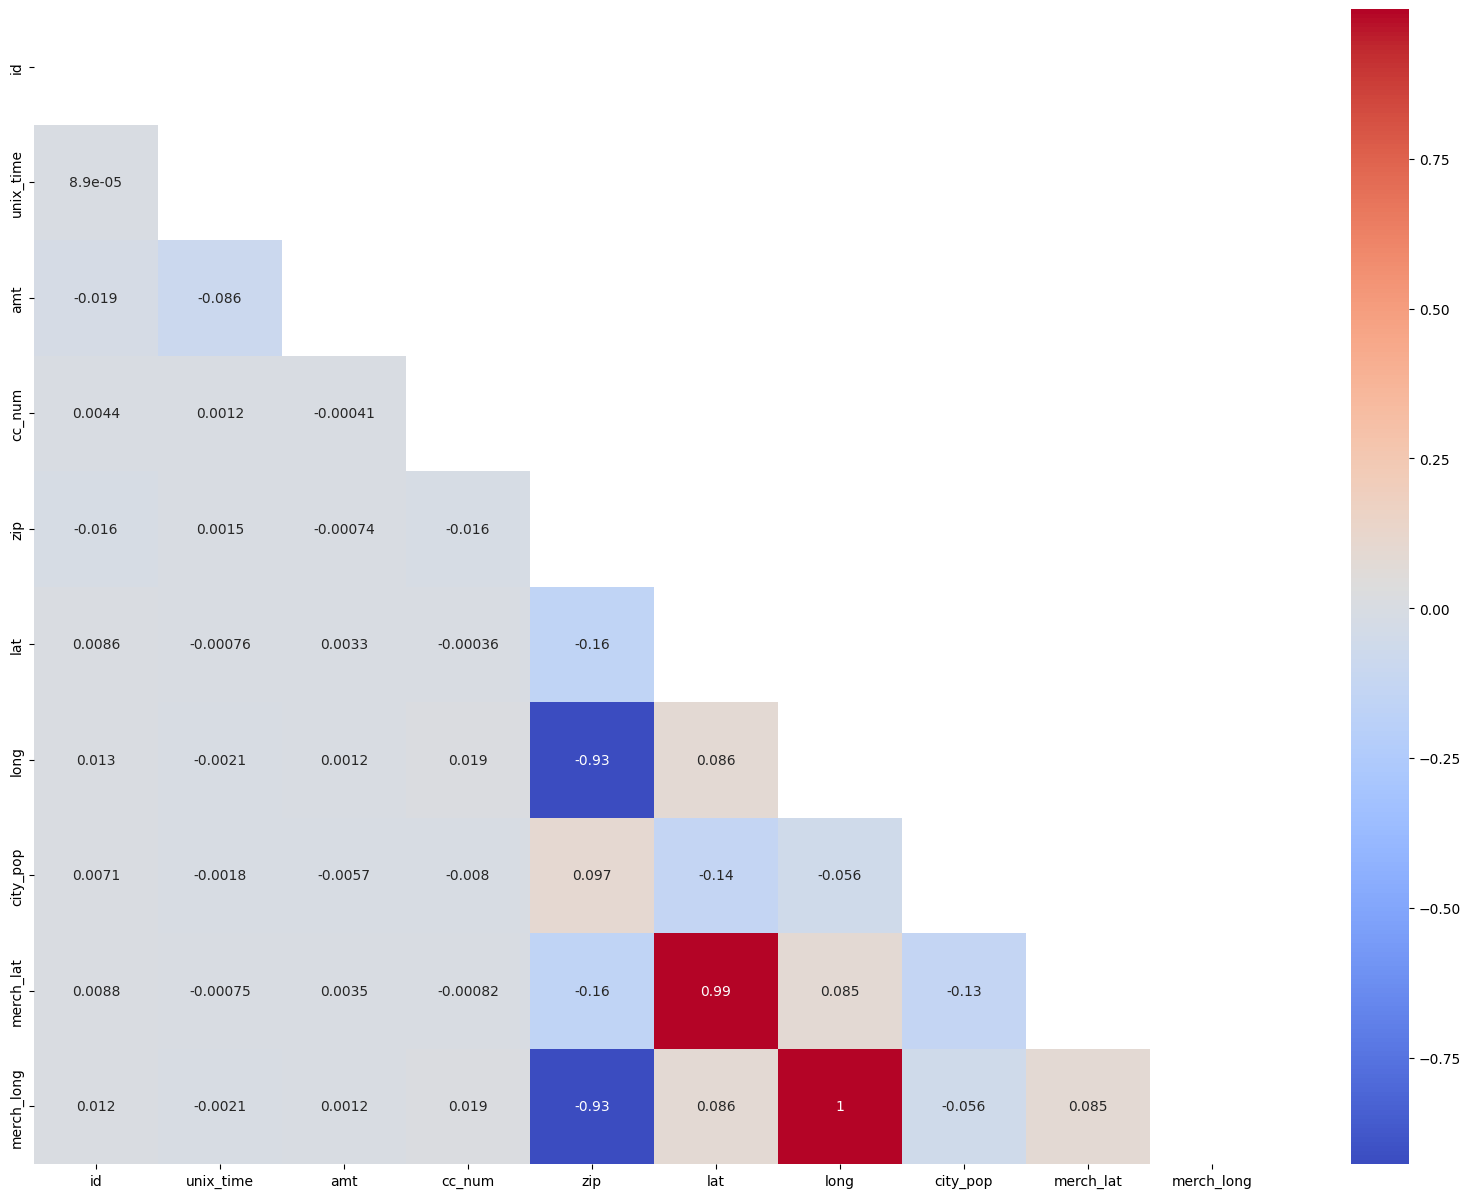

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_test_data = test_data.select_dtypes(include=[np.number])

# calculate the correlation matrix
corr_matrix = numeric_test_data.corr()

# create a mask to hide the upper triangle of the matrix (which is redundant)
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# plot the correlation matrix as a heatmap
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, ax=ax)

# find pairs of variables with high correlation (absolute value greater than a threshold)
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            high_corr_pairs.append((col_i, col_j, corr_matrix.iloc[i, j]))

print('Pairs of variables with high correlation:')
for pair in high_corr_pairs:
    print(pair)

In [56]:
# print unique and count for each column with object dtype
# for categorical columns, find count of each unique category
for col in test_data.columns:
    if test_data[col].dtype == 'object':
        print(f"{col}:\n{test_data[col].value_counts()}\n")

trans_num:
trans_num
2e6b34f2047158280fd5b50cb5249fcc    1
282011f01fa321319ee8c2ebab8625d2    1
fba0860598e65ef2986bbbe6e6541d28    1
64df441688ceb983fae29b5ab779fc2a    1
c674abe112444f328d77a488bbbfdbe4    1
                                   ..
db1ce30dc068c4ba65b9efb1f6320312    1
f6f4152005878ec43e6de092804bfe7c    1
a4ff9485affd0711de5b3bb59d193c07    1
e63e480d1cbb6224d4f2e6ddf4206cc0    1
001031e95e54824f3773a35ef9af03e4    1
Name: count, Length: 92676, dtype: int64

trans_date:
trans_date
2024-01-06    4271
2024-01-14    4252
2024-01-21    4241
2024-01-07    4180
2024-01-20    4155
2024-01-13    4155
2024-01-28    4068
2024-01-27    4014
2024-01-05    3626
2024-01-19    3569
2024-01-12    3500
2024-01-26    3365
2024-01-03    2756
2024-01-04    2682
2024-01-18    2668
2024-01-17    2664
2024-01-11    2579
2024-01-24    2578
2024-01-10    2572
2024-01-25    2486
2024-01-23    2435
2024-01-09    2428
2024-01-16    2387
2024-01-31    2370
2024-01-02    2341
2024-01-08    2131
20

In [57]:
train_ans.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [58]:
train_data.head()

,id,trans_date,trans_time,category,amt,gender,city,job,merchant,age,hour,hour_category
0,308467,2024-01-10,06:49:39,misc_pos,188.38,F,Belleville,Accounting technician,fraud_Turcotte-Halvorson,41,11,11
1,261578,2024-01-06,02:37:50,grocery_pos,102.63,F,Sykesville,"Designer, graphic",fraud_Schamberger-O'Keefe,48,7,7
2,341,2024-01-18,21:40:21,entertainment,1.62,M,Gaylord,Careers information officer,"fraud_Nicolas, Hills and McGlynn",25,2,2
3,1147639,2024-01-21,16:20:15,health_fitness,5.64,M,Medina,"Merchandiser, retail",fraud_Cormier LLC,94,21,21
4,314152,2024-01-21,19:36:26,health_fitness,97.09,F,Burbank,Prison officer,fraud_Kulas Group,73,0,0


In [59]:
train_data = train_data.drop('gender',axis=1) # no effect
# train_data = train_data.drop('hashed_cc_num',axis=1) #drop
train_data = train_data.drop('hour',axis=1) #drop
train_data.head()

,id,trans_date,trans_time,category,amt,city,job,merchant,age,hour_category
0,308467,2024-01-10,06:49:39,misc_pos,188.38,Belleville,Accounting technician,fraud_Turcotte-Halvorson,41,11
1,261578,2024-01-06,02:37:50,grocery_pos,102.63,Sykesville,"Designer, graphic",fraud_Schamberger-O'Keefe,48,7
2,341,2024-01-18,21:40:21,entertainment,1.62,Gaylord,Careers information officer,"fraud_Nicolas, Hills and McGlynn",25,2
3,1147639,2024-01-21,16:20:15,health_fitness,5.64,Medina,"Merchandiser, retail",fraud_Cormier LLC,94,21
4,314152,2024-01-21,19:36:26,health_fitness,97.09,Burbank,Prison officer,fraud_Kulas Group,73,0


In [60]:
print(train_data['merchant'].nunique())
print(train_data['category'].nunique())
print(train_data['city'].nunique())
print(train_data['job'].nunique())

693
14
4908
639


In [61]:
# define categorical columns to encode
cat_cols = ['merchant', 'city', 'job']

# create a label encoder object
le = LabelEncoder()

# loop through categorical columns and label encode them
for col in cat_cols:
    train_data[col] = le.fit_transform(train_data[col])

In [62]:
# One-hot encode the 'category' column
#one_hot = pd.get_dummies(train_data['category'])

# Add the one-hot encoded columns to the original DataFrame
#train_data = pd.concat([train_data, one_hot], axis=1)

# Drop the original 'category' column
#train_data.drop('category', axis=1, inplace=True)

# Check that 'category' are one-hot encoded
#print(train_data.columns)

In [63]:
import pandas as pd

# One-hot encode the 'category' column
one_hot = pd.get_dummies(train_data['category'])

# Add the one-hot encoded columns to the original DataFrame
train_data = pd.concat([train_data, one_hot], axis=1)

# Drop the original 'category' column
train_data.drop('category', axis=1, inplace=True)

# Select only the specified columns for training
columns_to_train = [
    'merchant', 'amt', 'city', 'job', 'age', 'hour_category',
    'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
    'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
    'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'
]

train_data = train_data[columns_to_train]

# Check that 'category' are one-hot encoded and only specified columns are present
print(train_data.columns)

Index(['merchant', 'amt', 'city', 'job', 'age', 'hour_category',
       'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
       'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
       'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'],
      dtype='object')


In [64]:
train_data.head(20)

,merchant,amt,city,job,age,hour_category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,638,188.38,315,6,41,11,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,550,102.63,4327,160,48,7,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,450,1.62,1633,80,25,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,105,5.64,2726,377,94,21,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,350,97.09,576,451,73,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False
5,534,109.29,2095,46,40,6,False,False,False,True,False,False,False,False,False,False,False,False,False,False
6,317,37.40,2136,424,41,19,True,False,False,False,False,False,False,False,False,False,False,False,False,False
7,602,183.37,2771,185,46,5,False,False,False,False,True,False,False,False,False,False,False,False,False,False
8,604,58.42,4155,372,27,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,268,1.12,546,511,33,8,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [65]:
train_data.dtypes

merchant             int64
amt                float64
city                 int64
job                  int64
age                  int64
hour_category     category
entertainment         bool
food_dining           bool
gas_transport         bool
grocery_net           bool
grocery_pos           bool
health_fitness        bool
home                  bool
kids_pets             bool
misc_net              bool
misc_pos              bool
personal_care         bool
shopping_net          bool
shopping_pos          bool
travel                bool
dtype: object

In [66]:
train_data['hour_category'] = train_data['hour_category'].astype('int64')

In [67]:
# # find out number of fraud cases
# train_fraud_counts = train_data.is_fraud.value_counts().reset_index(name="Count").rename(columns={'index':'is_fraud'})
# train_fraud_counts[train_fraud_counts["is_fraud"] == 1.0].Count
# train_fraud_counts["Percentage"] = train_fraud_counts["Count"]/len(train_data) * 100
# train_fraud_counts

In [68]:
# Ensure the 'is_fraud' column exists in the DataFrame
if 'is_fraud' in test_data.columns:
    # Find out number of fraud cases
    test_fraud_counts = test_data['is_fraud'].value_counts().reset_index(name="Count").rename(columns={'index': 'is_fraud'})
    test_fraud_counts["Percentage"] = test_fraud_counts["Count"] / len(test_data) * 100

    # Display the counts and percentages
    print(test_fraud_counts)
else:
    print("The 'is_fraud' column does not exist in the test_data DataFrame.")

The 'is_fraud' column does not exist in the test_data DataFrame.


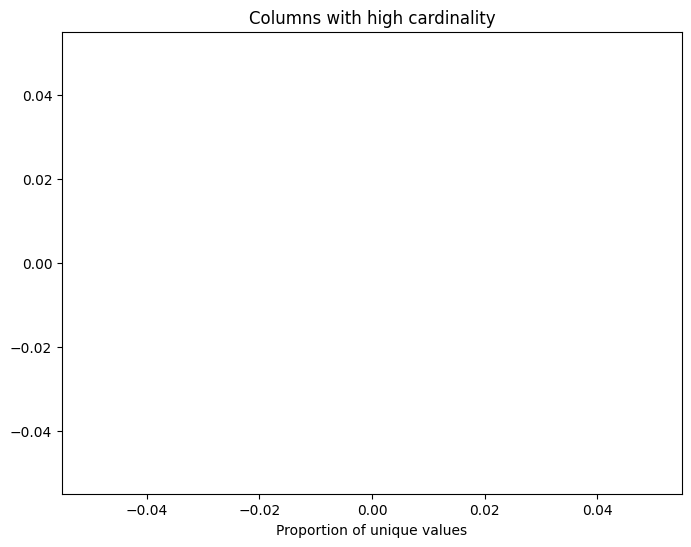

In [69]:
# calculate the proportion of unique values for each column
prop_unique = train_data.nunique() / len(train_data)

# select columns where the proportion of unique values is above a threshold
threshold = 0.5 # for example, 50%
high_card_cols = prop_unique[prop_unique > threshold]

# plot the proportion of unique values for each column
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(high_card_cols.index, high_card_cols.values)
ax.set_xlabel('Proportion of unique values')
ax.set_title('Columns with high cardinality')
plt.show()

In [70]:
train_data.head()

,merchant,amt,city,job,age,hour_category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,638,188.38,315,6,41,11,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,550,102.63,4327,160,48,7,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,450,1.62,1633,80,25,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,105,5.64,2726,377,94,21,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,350,97.09,576,451,73,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [71]:
import pandas as pd

# Check if 'category' column exists
if 'category' in train_data.columns:
    # One-hot encode the 'category' column
    one_hot = pd.get_dummies(train_data['category'])

    # Add the one-hot encoded columns to the original DataFrame
    train_data = pd.concat([train_data, one_hot], axis=1)

    # Drop the original 'category' column
    train_data.drop('category', axis=1, inplace=True)

    # Convert boolean columns to integers
    boolean_columns = one_hot.columns
    train_data[boolean_columns] = train_data[boolean_columns].astype(int)

# Select only the specified columns for training
columns_to_train = [
    'merchant', 'amt', 'city', 'job', 'age', 'hour_category',
    'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
    'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
    'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'
]

# Ensure all specified columns are present in the DataFrame
missing_columns = [col for col in columns_to_train if col not in train_data.columns]
if missing_columns:
    print(f"Missing columns in train_data: {missing_columns}")
else:
    train_data = train_data[columns_to_train]

    # Display the first few rows of the cleaned data
    print(train_data.head())

   merchant     amt  city  job  age  hour_category  entertainment  \
0       638  188.38   315    6   41             11          False   
1       550  102.63  4327  160   48              7          False   
2       450    1.62  1633   80   25              2           True   
3       105    5.64  2726  377   94             21          False   
4       350   97.09   576  451   73              0          False   

   food_dining  gas_transport  grocery_net  grocery_pos  health_fitness  \
0        False          False        False        False           False   
1        False          False        False         True           False   
2        False          False        False        False           False   
3        False          False        False        False            True   
4        False          False        False        False            True   

    home  kids_pets  misc_net  misc_pos  personal_care  shopping_net  \
0  False      False     False      True          False        

In [72]:
train_data.head()

,merchant,amt,city,job,age,hour_category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,638,188.38,315,6,41,11,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,550,102.63,4327,160,48,7,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,450,1.62,1633,80,25,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,105,5.64,2726,377,94,21,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,350,97.09,576,451,73,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [73]:
X_train, X_test, y_train, y_test = train_test_split(train_data,train_ans,test_size=0.2, random_state=14)

In [74]:
#pip install catboost

In [75]:
from catboost import CatBoostClassifier

In [76]:
# L1/L2, 0.1-10.0, lbfgs/liblinear/sag, auto/ovr/multinomial, 
LDA = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, n_components=None, store_covariance=False)
NB = GaussianNB()
CBC = CatBoostClassifier()
GBC = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
XGB = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)



In [77]:
# Step 6 : Train the model using split training data (X_train, y_train)
LDA.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [78]:
NB.fit(X_train,y_train)

GaussianNB()

In [79]:
CBC.fit(X_train,y_train)

Learning rate set to 0.117092
0:	learn: 0.4833825	total: 119ms	remaining: 1m 58s
1:	learn: 0.3534501	total: 173ms	remaining: 1m 26s
2:	learn: 0.2782285	total: 224ms	remaining: 1m 14s
3:	learn: 0.2276457	total: 267ms	remaining: 1m 6s
4:	learn: 0.1984141	total: 307ms	remaining: 1m 1s
5:	learn: 0.1733488	total: 349ms	remaining: 57.8s
6:	learn: 0.1615904	total: 391ms	remaining: 55.5s
7:	learn: 0.1491721	total: 449ms	remaining: 55.7s
8:	learn: 0.1428655	total: 488ms	remaining: 53.7s
9:	learn: 0.1336328	total: 524ms	remaining: 51.9s
10:	learn: 0.1305277	total: 567ms	remaining: 50.9s
11:	learn: 0.1272428	total: 611ms	remaining: 50.3s
12:	learn: 0.1255731	total: 661ms	remaining: 50.2s
13:	learn: 0.1241492	total: 705ms	remaining: 49.6s
14:	learn: 0.1213495	total: 747ms	remaining: 49s
15:	learn: 0.1188388	total: 782ms	remaining: 48.1s
16:	learn: 0.1171006	total: 816ms	remaining: 47.2s
17:	learn: 0.1163703	total: 854ms	remaining: 46.6s
18:	learn: 0.1144629	total: 891ms	remaining: 46s
19:	learn: 0

In [80]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [81]:
XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [82]:
print('Confusion matrix: LinearDiscriminantAnalysis')
print(confusion_matrix(y_test,LDA.predict(X_test)))
print('Classification report:')
print(classification_report(y_test,LDA.predict(X_test)))

Confusion matrix: LinearDiscriminantAnalysis


[[64969   646]
 [ 4422  4104]]
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     65615
           1       0.86      0.48      0.62      8526

    accuracy                           0.93     74141
   macro avg       0.90      0.74      0.79     74141
weighted avg       0.93      0.93      0.92     74141



In [83]:
print('Confusion matrix: GaussianNB')
print(confusion_matrix(y_test,NB.predict(X_test)))
print('Classification report:')
print(classification_report(y_test,NB.predict(X_test)))

Confusion matrix: GaussianNB
[[52054 13561]
 [ 2176  6350]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     65615
           1       0.32      0.74      0.45      8526

    accuracy                           0.79     74141
   macro avg       0.64      0.77      0.66     74141
weighted avg       0.89      0.79      0.82     74141



In [84]:
print('Confusion matrix: GradientBoostingClassifier')
print(confusion_matrix(y_test,GBC.predict(X_test)))
print('Classification report:')
print(classification_report(y_test,GBC.predict(X_test)))

Confusion matrix: GradientBoostingClassifier
[[64801   814]
 [ 2175  6351]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     65615
           1       0.89      0.74      0.81      8526

    accuracy                           0.96     74141
   macro avg       0.93      0.87      0.89     74141
weighted avg       0.96      0.96      0.96     74141



In [85]:
print('Confusion matrix: XGBoost')
print(confusion_matrix(y_test,XGB.predict(X_test)))
print('Classification report:')
print(classification_report(y_test,XGB.predict(X_test)))


Confusion matrix: XGBoost
[[64683   932]
 [ 1368  7158]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     65615
           1       0.88      0.84      0.86      8526

    accuracy                           0.97     74141
   macro avg       0.93      0.91      0.92     74141
weighted avg       0.97      0.97      0.97     74141



In [86]:
print('Confusion matrix: CatBoost')
print(confusion_matrix(y_test,CBC.predict(X_test)))
print('Classification report:')
print(classification_report(y_test,CBC.predict(X_test)))


Confusion matrix: CatBoost
[[64832   783]
 [ 1142  7384]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     65615
           1       0.90      0.87      0.88      8526

    accuracy                           0.97     74141
   macro avg       0.94      0.93      0.94     74141
weighted avg       0.97      0.97      0.97     74141



In [87]:
test_data.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,state,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long
0,52329,2e6b34f2047158280fd5b50cb5249fcc,2024-01-27,13:17:44,1706379464,kids_pets,13.00,30184874050384,Edward,Mueller,...,NY,11230,40.6225,-73.9650,2504700,Leisure centre manager,1955-12-17,"fraud_Lowe, Dietrich and Erdman",40.707029,-74.027386
1,92215,5e4c36e1e6f1838f0afe1ed83d42d48e,2024-01-31,21:12:51,1706753571,travel,25.64,3560293989785735,Ryan,Reeves,...,CA,92504,33.9315,-117.4119,419138,Mudlogger,1940-06-22,fraud_Johnston-Casper,34.344545,-117.348319
2,107070,de58b3413be0b956c261b8e756006b5d,2024-01-24,23:06:59,1706155619,home,99.48,213175392060268,Gregory,Graham,...,KY,42629,36.9680,-85.0968,4953,"Engineer, automotive",1993-03-18,"fraud_Gutmann, McLaughlin and Wiza",37.493843,-85.224136
3,117508,63e5e8954b6954121fb9395b8fb87ec3,2024-01-15,14:42:37,1705347757,grocery_pos,972.26,2720994415033785,Jessica,Carey,...,TX,75571,33.1808,-94.7639,2846,Geophysicist/field seismologist,1958-06-30,"fraud_Schoen, Kuphal and Nitzsche",32.238558,-94.085343
4,525132,f0acdc291ca35b61a873060e419b20a5,2024-01-30,22:02:41,1706670161,personal_care,165.04,639070744995,Corey,Rogers,...,NJ,7022,40.8170,-74.0000,13835,"Accountant, chartered public finance",1972-04-13,fraud_Sporer-Keebler,40.957527,-73.328707


In [88]:
# Assuming 'unix_time' is the column containing Unix time in your DataFrame
test_data['hour'] = pd.to_datetime(test_data['unix_time'], unit='s').dt.hour

# Categorize the hour column into 24 different categories according to 24 hours
test_data['hour_category'] = pd.cut(test_data['hour'], bins=24, labels=range(24))

In [89]:
# Convert 'dob' to datetime format
test_data['dob'] = pd.to_datetime(test_data['dob'])

# Get current date
today = datetime.today()

# Calculate age in years and save to new column
test_data['age'] = test_data['dob'].apply(lambda dob: relativedelta(today, dob).years)


In [90]:
test_data.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,long,city_pop,job,dob,merchant,merch_lat,merch_long,hour,hour_category,age
0,52329,2e6b34f2047158280fd5b50cb5249fcc,2024-01-27,13:17:44,1706379464,kids_pets,13.00,30184874050384,Edward,Mueller,...,-73.9650,2504700,Leisure centre manager,1955-12-17,"fraud_Lowe, Dietrich and Erdman",40.707029,-74.027386,18,18,68
1,92215,5e4c36e1e6f1838f0afe1ed83d42d48e,2024-01-31,21:12:51,1706753571,travel,25.64,3560293989785735,Ryan,Reeves,...,-117.4119,419138,Mudlogger,1940-06-22,fraud_Johnston-Casper,34.344545,-117.348319,2,2,84
2,107070,de58b3413be0b956c261b8e756006b5d,2024-01-24,23:06:59,1706155619,home,99.48,213175392060268,Gregory,Graham,...,-85.0968,4953,"Engineer, automotive",1993-03-18,"fraud_Gutmann, McLaughlin and Wiza",37.493843,-85.224136,4,4,31
3,117508,63e5e8954b6954121fb9395b8fb87ec3,2024-01-15,14:42:37,1705347757,grocery_pos,972.26,2720994415033785,Jessica,Carey,...,-94.7639,2846,Geophysicist/field seismologist,1958-06-30,"fraud_Schoen, Kuphal and Nitzsche",32.238558,-94.085343,19,19,66
4,525132,f0acdc291ca35b61a873060e419b20a5,2024-01-30,22:02:41,1706670161,personal_care,165.04,639070744995,Corey,Rogers,...,-74.0000,13835,"Accountant, chartered public finance",1972-04-13,fraud_Sporer-Keebler,40.957527,-73.328707,3,3,52


In [91]:
if 'is_fraud' not in test_data.columns:
    test_data['is_fraud'] = 0

test_ans = test_data['is_fraud']

In [92]:
# List of columns to drop
columns_to_drop = [
    'first', 'last', 'street', 'state', 'zip', 'lat', 'long', 'dob', 
    'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'cc_num', 'city_pop'
]

# Drop the specified columns if they exist
for column in columns_to_drop:
    if column in test_data.columns:
        test_data = test_data.drop(column, axis=1)

In [93]:
# List of columns to keep
columns_to_keep = [
    'merchant', 'category', 'amt', 'gender', 'city', 'job', 'hour', 'hour_category', 'age'
]

# Select only the specified columns
test_data = test_data[columns_to_keep]

In [94]:
# Display the first few rows of the cleaned data
print(test_data.head())

                             merchant       category     amt gender  \
0     fraud_Lowe, Dietrich and Erdman      kids_pets   13.00      M   
1               fraud_Johnston-Casper         travel   25.64      M   
2  fraud_Gutmann, McLaughlin and Wiza           home   99.48      M   
3   fraud_Schoen, Kuphal and Nitzsche    grocery_pos  972.26      F   
4                fraud_Sporer-Keebler  personal_care  165.04      M   

        city                                   job  hour hour_category  age  
0   Brooklyn                Leisure centre manager    18            18   68  
1  Riverside                             Mudlogger     2             2   84  
2  Jamestown                  Engineer, automotive     4             4   31  
3      Omaha       Geophysicist/field seismologist    19            19   66  
4   Fairview  Accountant, chartered public finance     3             3   52  


In [95]:
test_data = test_data.drop('gender',axis=1) # no effect
test_data = test_data.drop('hour',axis=1) #drop
test_data.head()

,merchant,category,amt,city,job,hour_category,age
0,"fraud_Lowe, Dietrich and Erdman",kids_pets,13.00,Brooklyn,Leisure centre manager,18,68
1,fraud_Johnston-Casper,travel,25.64,Riverside,Mudlogger,2,84
2,"fraud_Gutmann, McLaughlin and Wiza",home,99.48,Jamestown,"Engineer, automotive",4,31
3,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,972.26,Omaha,Geophysicist/field seismologist,19,66
4,fraud_Sporer-Keebler,personal_care,165.04,Fairview,"Accountant, chartered public finance",3,52


In [96]:
# define categorical columns to encode
cat_cols = ['merchant', 'city', 'job']

# create a label encoder object
le = LabelEncoder()

# loop through categorical columns and label encode them
for col in cat_cols:
    test_data[col] = le.fit_transform(test_data[col])

In [97]:
# One-hot encode the 'category' column
one_hot = pd.get_dummies(test_data['category'])

# Add the one-hot encoded columns to the original DataFrame
test_data = pd.concat([test_data, one_hot], axis=1)

# Drop the original 'category' column
test_data.drop('category', axis=1, inplace=True)

# Check that 'category' are one-hot encoded
print(test_data.columns)

Index(['merchant', 'amt', 'city', 'job', 'hour_category', 'age',
       'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
       'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
       'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'],
      dtype='object')


In [98]:
test_data.dtypes

merchant             int64
amt                float64
city                 int64
job                  int64
hour_category     category
age                  int64
entertainment         bool
food_dining           bool
gas_transport         bool
grocery_net           bool
grocery_pos           bool
health_fitness        bool
home                  bool
kids_pets             bool
misc_net              bool
misc_pos              bool
personal_care         bool
shopping_net          bool
shopping_pos          bool
travel                bool
dtype: object

In [99]:
test_data['hour_category'] = test_data['hour_category'].astype('int64')

In [100]:
test_data.dtypes

merchant            int64
amt               float64
city                int64
job                 int64
hour_category       int64
age                 int64
entertainment        bool
food_dining          bool
gas_transport        bool
grocery_net          bool
grocery_pos          bool
health_fitness       bool
home                 bool
kids_pets            bool
misc_net             bool
misc_pos             bool
personal_care        bool
shopping_net         bool
shopping_pos         bool
travel               bool
dtype: object

In [101]:
# Get the column names of the dataframe
cols = test_data.columns.tolist()

# Find the indices of the columns we want to swap
idx_age = cols.index('age')
idx_hour = cols.index('hour_category')

# Swap the column names in the list
cols[idx_age], cols[idx_hour] = cols[idx_hour], cols[idx_age]

# Reindex the dataframe with the new column order
test_data = test_data.reindex(columns=cols)
test_data.head()

,merchant,amt,city,job,age,hour_category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
0,396,13.00,504,345,68,18,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,292,25.64,3558,385,84,2,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,213,99.48,2034,197,31,4,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,563,972.26,3083,276,66,19,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,591,165.04,1363,5,52,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [102]:
print('Confusion matrix: LinearDiscriminantAnalysis')
print(confusion_matrix(test_ans,LDA.predict(test_data)))
print('Classification report:')
print(classification_report(test_ans,LDA.predict(test_data)))


Confusion matrix: LinearDiscriminantAnalysis


[[86836  5840]
 [    0     0]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     92676
           1       0.00      0.00      0.00         0

    accuracy                           0.94     92676
   macro avg       0.50      0.47      0.48     92676
weighted avg       1.00      0.94      0.97     92676



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
print('Confusion matrix: GaussianNB')
print(confusion_matrix(test_ans,NB.predict(test_data)))
print('Classification report:')
print(classification_report(test_ans,NB.predict(test_data)))

Confusion matrix: GaussianNB
[[67824 24852]
 [    0     0]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85     92676
           1       0.00      0.00      0.00         0

    accuracy                           0.73     92676
   macro avg       0.50      0.37      0.42     92676
weighted avg       1.00      0.73      0.85     92676



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [104]:
# Print confusion matrix and classification report for GradientBoostingClassifier
print('Confusion matrix: GradientBoostingClassifier')
print(confusion_matrix(test_ans, GBC.predict(test_data)))
print('Classification report:')
print(classification_report(test_ans, GBC.predict(test_data)))

Confusion matrix: GradientBoostingClassifier
[[83887  8789]
 [    0     0]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     92676
           1       0.00      0.00      0.00         0

    accuracy                           0.91     92676
   macro avg       0.50      0.45      0.48     92676
weighted avg       1.00      0.91      0.95     92676



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
print('Confusion matrix: XGBoost')
print(confusion_matrix(test_ans,XGB.predict(test_data)))
print('Classification report:')
print(classification_report(test_ans,XGB.predict(test_data)))

Confusion matrix: XGBoost
[[82752  9924]
 [    0     0]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     92676
           1       0.00      0.00      0.00         0

    accuracy                           0.89     92676
   macro avg       0.50      0.45      0.47     92676
weighted avg       1.00      0.89      0.94     92676



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [106]:
print('Confusion matrix: CatBoost')
print(confusion_matrix(test_ans,CBC.predict(test_data)))
print('Classification report:')
print(classification_report(test_ans,CBC.predict(test_data)))

Confusion matrix: CatBoost
[[82487 10189]
 [    0     0]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     92676
           1       0.00      0.00      0.00         0

    accuracy                           0.89     92676
   macro avg       0.50      0.45      0.47     92676
weighted avg       1.00      0.89      0.94     92676



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [107]:
joblib.dump(CBC, 'cbc_fraud_model.pkl')

['cbc_fraud_model.pkl']

In [108]:
# These are the feature labels from your data set
feature_labels = np.array(['merchant', 'amt', 'city', 'job', 'hour_category', 'age', 'entertainment', 'food_dining', 'gas_transport', 'grocery_net', 'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net', 'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'])

# Load the trained model created with train_model.py
model = joblib.load('cbc_fraud_model.pkl')

# Create a numpy array based on the model's feature importances
importance = model.feature_importances_

# Sort the feature labels based on the feature importance rankings from the model in descending order
feature_indexes_by_importance = (-importance).argsort()

# Print each feature label, from least important to most important
for index in feature_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))


amt - 4253.64%
age - 2252.22%
hour_category - 1295.60%
shopping_pos - 317.21%
shopping_net - 269.45%
entertainment - 197.14%
grocery_pos - 169.14%
gas_transport - 166.48%
misc_net - 157.40%
city - 126.51%
home - 125.63%
job - 117.25%
food_dining - 104.14%
merchant - 95.73%
kids_pets - 82.33%
grocery_net - 76.28%
misc_pos - 65.04%
health_fitness - 60.22%
personal_care - 51.89%
travel - 16.70%


In [ ]:
test_data.head()

,merchant,amt,city,job,age,hour_category,entertainment,food_dining,gas_transport,grocery_net,...,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel,is_fraud
0,396,13.00,504,345,68,18,False,False,False,False,...,False,False,True,False,False,False,False,False,False,0
1,292,25.64,3558,385,84,2,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0
2,213,99.48,2034,197,31,4,False,False,False,False,...,False,True,False,False,False,False,False,False,False,0
3,563,972.26,3083,276,66,19,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,591,165.04,1363,5,52,3,False,False,False,False,...,False,False,False,False,False,True,False,False,False,0


In [ ]:
# Load test.csv to get the 'id' column
test_csv = pd.read_csv('test.csv')

# Predict using  model
test_data['is_fraud'] = CBC.predict(test_data)

# Prepare the submission file with the required format
submission = pd.DataFrame({
    'id': test_csv['id'], 
    'is_fraud': test_data['is_fraud']
})

# Save the submission file
submission.to_csv('submission_CBC.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import f1_score

param_grid_lda = [
    {'solver': ['svd'], 'shrinkage': [None]},
    {'solver': ['lsqr'], 'shrinkage': [None, 'auto']}
]

param_grid_cbc = {
    'iterations': [100],
    'depth': [3, 4],
    'learning_rate': [0.1]
}

param_grid_gbc = {
    'n_estimators': [100],
    'max_depth': [3, 4],
    'learning_rate': [0.1]
}

param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [3, 4],
    'learning_rate': [0.1]
}

lda = LinearDiscriminantAnalysis()
nb = GaussianNB()
cbc = CatBoostClassifier(verbose=0)
gbc = GradientBoostingClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=3, scoring='f1')
grid_search_cbc = GridSearchCV(cbc, param_grid_cbc, cv=3, scoring='f1')
grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, cv=3, scoring='f1')
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='f1')

grid_search_lda.fit(X_train, y_train)
grid_search_cbc.fit(X_train, y_train)
grid_search_gbc.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)

best_lda = grid_search_lda.best_estimator_
best_cbc = grid_search_cbc.best_estimator_
best_gbc = grid_search_gbc.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

print("Best parameters for LDA:", grid_search_lda.best_params_)
print("Best parameters for CBC:", grid_search_cbc.best_params_)
print("Best parameters for GBC:", grid_search_gbc.best_params_)
print("Best parameters for XGB:", grid_search_xgb.best_params_)

y_pred_lda = best_lda.predict(X_test)
y_pred_cbc = best_cbc.predict(X_test)
y_pred_gbc = best_gbc.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

f1_lda = f1_score(y_test, y_pred_lda)
f1_cbc = f1_score(y_test, y_pred_cbc)
f1_gbc = f1_score(y_test, y_pred_gbc)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("F1 score for LDA:", f1_lda)
print("F1 score for CBC:", f1_cbc)
print("F1 score for GBC:", f1_gbc)
print("F1 score for XGB:", f1_xgb)

Best parameters for LDA: {'shrinkage': None, 'solver': 'svd'}
Best parameters for CBC: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
Best parameters for GBC: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best parameters for XGB: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
F1 score for LDA: 0.6182585115998794
F1 score for CBC: 0.8363302752293578
F1 score for GBC: 0.8479652215915953
F1 score for XGB: 0.8447272727272728


In [117]:
import pandas as pd

# Load test.csv to get the 'id' column
test_csv = pd.read_csv('test.csv')

# Assuming test_data is already preprocessed and ready for prediction
# Predict using CatBoostClassifier model
test_data['is_fraud'] = best_cbc.predict(test_data)

# Prepare the submission file with the required format
submission = pd.DataFrame({
    'id': test_csv['id'], 
    'is_fraud': test_data['is_fraud']
})

# Save the submission file
submission.to_csv('submission_CBC_1.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

       id  is_fraud
0   52329         0
1   92215         0
2  107070         0
3  117508         1
4  525132         0
